## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result


## 1 - Imports

In [3]:
import tensorflow
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from plot_keras_history import plot_history


## 2 - Récupérer les données

In [2]:
data_river = pd.read_csv("../databases/HYDROSWOT_100m_acc_clim_lc_beck.csv", sep=";")
display(data_river.head(5).style.set_caption("Few lines of the dataset :"))
print('Missing Data : ',data_river.isna().sum().sum(), '  Shape is : ', data_river.shape)

,site_no,station_name,lon,lat,flowacc,stage,W,dH,dA,U,clay,sand,silt,PA,TA,LC1,LC2,LC3,LC4,LC5,LC6,LC7,LC8,LC9,LC10,LC11,LC12,Q5_GSCD,Q10_GSCD,Q20_GSCD,QMEAN_GSCD,Q80_GSCD,Q90_GSCD,Q95_GSCD,Q
0,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.580000,47.280000,15356.039445,2.331720,196.291200,1.938528,240.439534,0.347472,16.586207,41.051724,42.448276,1029.777778,2.918806,4.363636,0.206612,20.264463,50.446281,0.000000,2.239669,12.735537,2.826446,5.826446,0.000000,0.000000,1.190083,99502.325185,61157.019143,33797.196081,9594206.104266,6429.734027,4146.406794,3498.886439,56.916862
1,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.580000,47.280000,15356.039445,2.654808,219.456000,2.261616,300.786608,0.667512,16.586207,41.051724,42.448276,1029.777778,2.918806,4.363636,0.206612,20.264463,50.446281,0.000000,2.239669,12.735537,2.826446,5.826446,0.000000,0.000000,1.190083,99502.325185,61157.019143,33797.196081,9594206.104266,6429.734027,4146.406794,3498.886439,87.782224
2,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.580000,47.280000,15356.039445,2.712720,190.500000,2.319528,312.657294,0.966216,16.586207,41.051724,42.448276,1029.777778,2.918806,4.363636,0.206612,20.264463,50.446281,0.000000,2.239669,12.735537,2.826446,5.826446,0.000000,0.000000,1.190083,99502.325185,61157.019143,33797.196081,9594206.104266,6429.734027,4146.406794,3498.886439,529.525031
3,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.580000,47.280000,15356.039445,6.263640,202.387200,5.870448,1033.768321,1.996440,16.586207,41.051724,42.448276,1029.777778,2.918806,4.363636,0.206612,20.264463,50.446281,0.000000,2.239669,12.735537,2.826446,5.826446,0.000000,0.000000,1.190083,99502.325185,61157.019143,33797.196081,9594206.104266,6429.734027,4146.406794,3498.886439,2500.377554
4,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.580000,47.280000,15356.039445,7.150608,206.044800,6.757416,1220.685874,2.209800,16.586207,41.051724,42.448276,1029.777778,2.918806,4.363636,0.206612,20.264463,50.446281,0.000000,2.239669,12.735537,2.826446,5.826446,0.000000,0.000000,1.190083,99502.325185,61157.019143,33797.196081,9594206.104266,6429.734027,4146.406794,3498.886439,3228.120511


Missing Data :  34   Shape is :  (16828, 35)


In [4]:
# Missing data = 34 => présence de valeurs NaN dans le tableau => on les retire

data_river.dropna(inplace=True)
display(data_river.head(5).style.set_caption("Few lines of the dataset :"))
print('Missing Data : ',data_river.isna().sum().sum(), 'Shape is : ', data_river.shape )

,site_no,station_name,lon,lat,flowacc,stage,W,dH,dA,U,clay,sand,silt,PA,TA,LC1,LC2,LC3,LC4,LC5,LC6,LC7,LC8,LC9,LC10,LC11,LC12,Q5_GSCD,Q10_GSCD,Q20_GSCD,QMEAN_GSCD,Q80_GSCD,Q90_GSCD,Q95_GSCD,Q
0,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.580000,47.280000,15356.039445,2.331720,196.291200,1.938528,240.439534,0.347472,16.586207,41.051724,42.448276,1029.777778,2.918806,4.363636,0.206612,20.264463,50.446281,0.000000,2.239669,12.735537,2.826446,5.826446,0.000000,0.000000,1.190083,99502.325185,61157.019143,33797.196081,9594206.104266,6429.734027,4146.406794,3498.886439,56.916862
1,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.580000,47.280000,15356.039445,2.654808,219.456000,2.261616,300.786608,0.667512,16.586207,41.051724,42.448276,1029.777778,2.918806,4.363636,0.206612,20.264463,50.446281,0.000000,2.239669,12.735537,2.826446,5.826446,0.000000,0.000000,1.190083,99502.325185,61157.019143,33797.196081,9594206.104266,6429.734027,4146.406794,3498.886439,87.782224
2,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.580000,47.280000,15356.039445,2.712720,190.500000,2.319528,312.657294,0.966216,16.586207,41.051724,42.448276,1029.777778,2.918806,4.363636,0.206612,20.264463,50.446281,0.000000,2.239669,12.735537,2.826446,5.826446,0.000000,0.000000,1.190083,99502.325185,61157.019143,33797.196081,9594206.104266,6429.734027,4146.406794,3498.886439,529.525031
3,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.580000,47.280000,15356.039445,6.263640,202.387200,5.870448,1033.768321,1.996440,16.586207,41.051724,42.448276,1029.777778,2.918806,4.363636,0.206612,20.264463,50.446281,0.000000,2.239669,12.735537,2.826446,5.826446,0.000000,0.000000,1.190083,99502.325185,61157.019143,33797.196081,9594206.104266,6429.734027,4146.406794,3498.886439,2500.377554
4,1014000,"St. John River below Fish R, nr Fort Kent, Maine",-68.580000,47.280000,15356.039445,7.150608,206.044800,6.757416,1220.685874,2.209800,16.586207,41.051724,42.448276,1029.777778,2.918806,4.363636,0.206612,20.264463,50.446281,0.000000,2.239669,12.735537,2.826446,5.826446,0.000000,0.000000,1.190083,99502.325185,61157.019143,33797.196081,9594206.104266,6429.734027,4146.406794,3498.886439,3228.120511


Missing Data :  0 Shape is :  (16794, 35)


## 3 - Préparation des données
### 3.1 Suppresion des valeurs aberrantes

In [1]:
# to be continued

### 3.2 Choisir les données

In [5]:
to_drop = ['site_no','lon','lat','station_name','U', 'Q5_GSCD','Q10_GSCD','Q20_GSCD','QMEAN_GSCD','Q80_GSCD','Q90_GSCD',
           'Q95_GSCD','LC1','LC2','LC3','LC4','LC5','LC6','LC7','LC8','LC9','LC10','LC11','LC12','clay','sand','silt','PA','TA']

# Pas U mais flowacc

# Pente du terrain

#Autre méthode
#columns_used=['date','pmer','tend','cod_tend','dd','ff','td','u','ww','pres','rafper','per','rr1','rr3','tc']

# ---- Drop unused columns

#to_drop = df.columns.difference(columns_used)
#df.drop( to_drop, axis=1, inplace=True)


data = data_river.drop(to_drop,axis=1)

display(data.head(5).style.set_caption("Few lines of the dataset :"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,flowacc,stage,W,dH,dA,Q
0,15356.039445,2.331720,196.291200,1.938528,240.439534,56.916862
1,15356.039445,2.654808,219.456000,2.261616,300.786608,87.782224
2,15356.039445,2.712720,190.500000,2.319528,312.657294,529.525031
3,15356.039445,6.263640,202.387200,5.870448,1033.768321,2500.377554
4,15356.039445,7.150608,206.044800,6.757416,1220.685874,3228.120511


Missing Data :  0   Shape is :  (16794, 6)


### 3.2 Séparer les données

80% pour train - 20% pour test

x -> input data

y -> expected output

In [6]:
# ---- Suffle and Split => train, test

data_train = data.sample(frac=0.8, axis=0) # peut être fait avec n = 'nombre de données voulues'
data_test  = data.drop(data_train.index) # retire les données choisies
display(data_train.head())

# ---- Split => x,y
#
x_train = data_train.drop('Q',  axis=1)
y_train = data_train['Q'] 
x_test  = data_test.drop('Q',   axis=1)
y_test  = data_test['Q']


print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)


,flowacc,stage,W,dH,dA,Q
4088,62418.713210,1.475232,134.112000,0.905256,119.360107,265.045684
12032,12406.042999,2.377440,152.095200,1.633728,252.648052,317.148682
15037,36259.833400,0.475488,154.957272,0.286512,36.690198,26.418202
2430,10207.143102,1.786128,195.376800,1.185672,231.639223,156.903647
11462,11551.346926,0.024384,49.444656,0.381000,14.886695,27.939383


Original data shape was :  (16794, 6)
x_train :  (13435, 5) y_train :  (13435,)
x_test  :  (3359, 5) y_test  :  (3359,)


### 3.3 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will **subtract the mean** and **divide by the standard deviation**.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [7]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std


#mean = y_train.mean()
#std  = y_train.std()

#y_train = (y_train - mean) / std
#y_test  = (y_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))
display(x_train.head(5).style.format("{0:.2f}").set_caption("Few lines of the dataset :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,flowacc,stage,W,dH,dA
count,13435.00,13435.00,13435.00,13435.00,13435.00
mean,306619.58,7.01,213.57,2.20,511.08
std,542579.80,26.25,194.73,14.12,2095.51
min,339.29,-3.95,10.22,0.00,0.00
25%,14226.80,1.57,118.47,0.39,51.59
50%,32641.62,3.08,160.32,1.09,155.56
75%,289560.67,5.08,216.47,2.38,408.80
max,2929652.09,1423.42,3291.84,1422.32,183221.79


,flowacc,stage,W,dH,dA
count,13435.00,13435.00,13435.00,13435.00,13435.00
mean,0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-0.56,-0.42,-1.04,-0.16,-0.24
25%,-0.54,-0.21,-0.49,-0.13,-0.22
50%,-0.50,-0.15,-0.27,-0.08,-0.17
75%,-0.03,-0.07,0.01,0.01,-0.05
max,4.83,53.95,15.81,100.56,87.19


,flowacc,stage,W,dH,dA
4088,-0.45,-0.21,-0.41,-0.09,-0.19
12032,-0.54,-0.18,-0.32,-0.04,-0.12
15037,-0.50,-0.25,-0.30,-0.14,-0.23
2430,-0.55,-0.20,-0.09,-0.07,-0.13
11462,-0.54,-0.27,-0.84,-0.13,-0.24


# Step 4 - Build a model
About informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [8]:
def get_model_v1(shape,n_layers,n_neurons): 
    
    # shape : nb de variables explicatives 
    # n_layers : nb de couches
    # n_neurons : neurons/ couche
   
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    
    for i in range(n_layers): 
            model.add(keras.layers.Dense(n_neurons, activation='relu', name='Dense_n'+str(i)))
   
    model.add(keras.layers.Dense(1, name='Output'))
    model.compile(optimizer = 'adam', 
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [9]:
shape = data.shape[1]-1
n_layers = 5
n_neurons = 32
model=get_model_v1((shape,),n_layers,n_neurons)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n0 (Dense)             (None, 32)                192       
_________________________________________________________________
Dense_n1 (Dense)             (None, 32)                1056      
_________________________________________________________________
Dense_n2 (Dense)             (None, 32)                1056      
_________________________________________________________________
Dense_n3 (Dense)             (None, 32)                1056      
_________________________________________________________________
Dense_n4 (Dense)             (None, 32)                1056      
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Tota

### 5.2 Train it

In [27]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size = 50, 
                    verbose         = 0,
                    validation_data = (x_test, y_test))

AttributeError: 'History' object has no attribute 'columns'

## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [32]:
score = model.evaluate(x_test, y_test, verbose=1)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

3359/3359 [==============================] - 0s 40us/sample - loss: 215321.8143 - mean_absolute_error: 191.9254 - mean_squared_error: 215321.7969
x_test / loss      : 215321.8143
x_test / mae       : 191.9254
x_test / mse       : 215321.7969


### 6.2 - Training history
What was the best result during our training ?

In [71]:
df=pd.DataFrame(data=history.history)
display(df.head().style.format("{0:.2f}").set_caption("Début du training:"))
display(df.tail().style.format("{0:.2f}").set_caption("Fin du training :"))

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
0,319457.24,239.13,319457.22,278671.82,217.82,278671.78
1,304836.14,230.68,304836.22,264336.55,210.23,264336.53
2,312166.82,236.10,312166.81,296221.00,228.92,296221.06
3,304301.74,232.39,304301.66,279440.50,213.46,279440.50
4,303284.49,231.74,303284.31,258161.43,205.38,258161.47


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
95,226028.57,208.67,226028.53,214496.48,186.97,214496.48
96,216954.74,206.59,216954.73,223434.96,206.28,223434.97
97,222008.74,205.90,222008.70,336899.51,282.94,336899.47
98,223344.38,212.62,223344.42,281722.00,218.86,281721.97
99,222832.78,206.73,222832.86,215321.82,191.93,215321.88


In [36]:
print("min( val_mae ) : {:.4f}".format( min(df["val_mean_absolute_error"]) ) )

min( val_mae ) : 0.0507


In [54]:
mod_pred = model.predict(x_train)
y_train = y_train.reshape(13435,1)

In [66]:
y = abs(y_train - mod_pred)/abs(y_train)

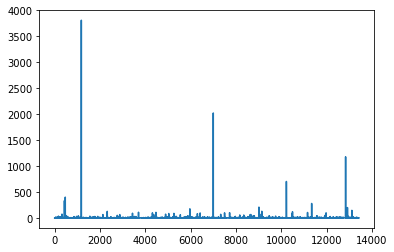

In [67]:
plt.plot(y)

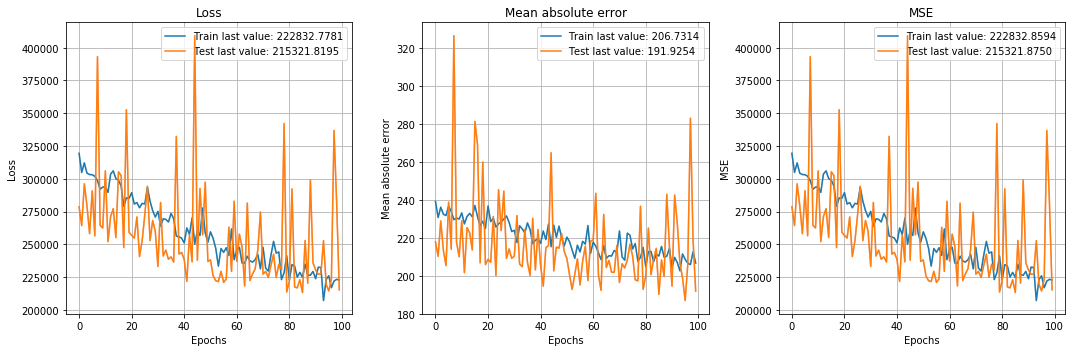

In [40]:
plot_history(df)

No handles with labels found to put in legend.


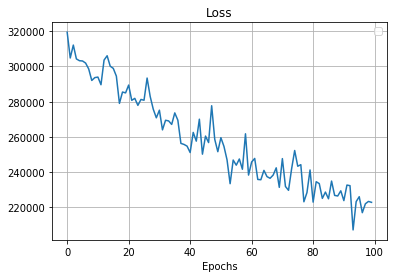

No handles with labels found to put in legend.


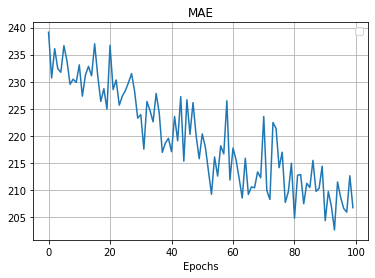

In [68]:
plt.plot(df['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

plt.plot(df['mean_absolute_error'])
plt.title('MAE')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

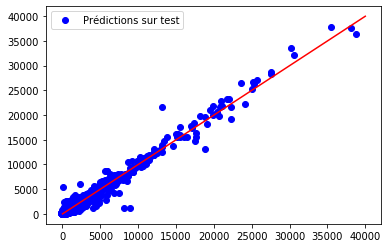

In [31]:
plt.plot(y_test,model.predict(x_test),'bo',label='Prédictions sur test')
x = np.arange(0,40000)
plt.plot(x,x,'r')
plt.legend()


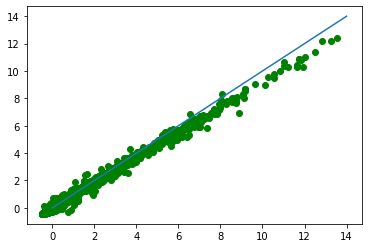

In [42]:
# en option 
plt.plot(y_train,model.predict(x_train),'go')
plt.plot(x,x)
plt.show()


## Step 7 - Make a prediction
The data must be normalized with the parameters (mean, std) previously used.

In [140]:
my_data =[-90.19,41.82,3.523488,161.848800,0.518160,81.193146,0.481584]

real_price = 314.316997

my_data=np.array(my_data).reshape(1,7)

In [141]:
predictions = model.predict( my_data )


print("Prediction : {:.2f} ".format(predictions[0][0]))
print("Reality    : {:.2f} ".format(real_price))

Prediction : 2948.38 
Reality    : 314.32 


In [142]:
print("Weights and biases of the layers after training the model: \n")
for layer in model.layers:
    print("Layer : " , layer.name)
    print("Weights : ",layer.get_weights()[0].shape)
    print(layer.get_weights()[0])
    print("Bias")
    print("Shape: ",layer.get_weights()[1].shape,'\n',layer.get_weights()[1],'\n')

Weights and biases of the layers after training the model: 

Layer :  Dense_n0
Weights :  (7, 64)
[[ 3.07103395e-01  1.27478993e+00  1.64700162e+00  5.99168837e-01
  -3.44721198e-01  2.89686680e-01 -4.51515764e-01  3.73953581e-01
  -1.06281114e+00  6.62443876e-01  1.35890460e+00 -5.50450861e-01
  -9.95901644e-01 -7.23183453e-01 -3.33143622e-01  3.53815593e-02
  -6.04286730e-01 -1.38661861e-02 -7.10117877e-01  7.41765320e-01
   8.06051075e-01 -2.88582414e-01 -3.78332883e-01  1.02474833e+00
   6.80721760e-01 -9.60029364e-01 -1.03810441e+00  8.09304953e-01
  -1.32917404e+00 -1.06747663e+00  1.80283234e-01 -3.64609331e-01
   6.41464174e-01  2.14270338e-01  1.27784967e+00 -3.91436398e-01
   1.87493610e+00 -3.34782675e-02 -4.49769825e-01  4.76720065e-01
   3.53112146e-02  1.30928028e+00 -4.02405709e-01 -6.09946907e-01
  -1.31196249e+00 -5.45366883e-01 -4.05987427e-02 -7.34008908e-01
   1.82739520e+00 -1.43755436e+00 -4.53540720e-02 -1.16918397e+00
  -9.65871096e-01 -9.05186594e-01  5.5297136

Weights :  (64, 64)
[[-0.13730201 -1.0934339  -0.19328812 ... -0.30747294  2.2614193
  -0.47356734]
 [-0.01755584  0.06575474  0.04870887 ... -0.18453029 -1.7903695
  -0.08653504]
 [-0.17054781  0.02689682 -1.7384937  ... -0.12957063 -1.6708009
  -0.02564705]
 ...
 [ 0.06197496 -0.34082517 -4.601283   ... -0.29205278  0.69713503
  -3.2433224 ]
 [ 0.14462902 -0.01264427 -0.8436549  ...  0.07247286  0.15856457
  -0.40255144]
 [-0.21891655  1.1909639  -0.27043468 ... -0.26645052 -1.049632
  -0.85263926]]
Bias
Shape:  (64,) 
 [-0.12299785  0.80011314  0.3260968  -0.43528253 -0.7008148   1.074539
 -0.34073603 -0.21081485  0.96185195 -0.51565725  0.5160891   0.8920906
 -0.13227706 -0.11180595 -0.17230693 -0.1544036   0.5252307   0.76035523
 -0.39905462 -0.8094035  -0.11841809 -1.0926245  -0.5864007  -0.10797369
 -0.11370502 -0.18930842 -0.10432136 -0.01553745 -0.48370686  0.05634528
  0.5670555  -0.07033372  0.6339706  -0.13758181 -0.35485935 -0.13580824
  0.40676764 -0.40015715 -0.1171677  

Weights :  (64, 64)
[[-0.21196975  0.17844665  0.01505133 ...  0.04313596  0.14336528
  -0.0194536 ]
 [-0.23339744  0.11284888 -0.15482359 ...  0.00079644 -0.1586053
  -0.01833719]
 [-0.09018026  0.09414639  0.16403025 ...  0.03968765 -0.19976704
   0.16357055]
 ...
 [ 0.18748595 -0.25313982  0.08126005 ...  0.18938829 -0.07059452
  -0.0581933 ]
 [-0.01129458  0.14251985  0.14587326 ...  0.17841618 -0.01725736
  -0.2179298 ]
 [-0.05208103 -0.07902487 -0.16160372 ... -0.3337891  -0.12256015
   0.07958848]]
Bias
Shape:  (64,) 
 [-5.29036745e-02  2.01995019e-03  1.79885507e-01 -5.45407534e-02
 -4.53694724e-02 -1.08871935e-02 -3.06848343e-02 -6.54178336e-02
 -6.56123683e-02 -9.11924466e-02 -8.49827603e-02 -9.19833109e-02
 -8.61421004e-02 -3.13001941e-03 -5.81788644e-03 -2.44979877e-02
 -1.08111545e-01 -6.56370297e-02  5.56672394e-01 -1.26019185e-02
 -1.98253784e-02 -2.60479320e-02 -6.65942654e-02  9.82903875e-03
 -3.90294008e-02  5.22544205e-01 -5.85912019e-02 -2.53677126e-02
 -1.09892376e

Weights :  (64, 64)
[[-0.28290352 -0.22271751  0.18576278 ...  0.04625253  0.03037668
   0.17949207]
 [ 0.14536858  0.18846999 -0.15760796 ... -0.17690401 -0.18634091
   0.09601828]
 [ 0.0842415   0.12204333 -0.16572437 ...  0.17255116 -0.0196149
   0.13503881]
 ...
 [-0.1608882   0.1652574   0.02539145 ...  0.20455895  0.07274809
   0.02824954]
 [ 0.00842934  0.09068308 -0.05257038 ... -0.03442573  0.05815662
   0.1914559 ]
 [ 0.05004683  0.08459026 -0.1844675  ... -0.13040353 -0.07034634
   0.18650262]]
Bias
Shape:  (64,) 
 [ 0.00875919  0.7519911  -0.06421652 -0.06689118  0.08872394  0.04413887
  0.8532363   0.03822384 -0.151173   -0.02948571  0.64718574  0.03982479
  0.00185403 -0.10928064  0.03375098 -0.11708363  0.12623027  0.12388258
 -0.09056077  0.02637225 -0.15554407 -0.03912532 -0.11355969 -0.00532683
  0.16384234  0.10824928 -0.07221483  0.8194475  -0.07135835  0.0940779
 -0.03094686 -0.01231426  0.01671247  0.00890514 -0.06164132 -0.05055094
  0.0145422  -0.02543734 -0.047

Weights :  (64, 64)
[[-0.28941107 -0.27351224 -0.15087077 ... -0.25130945 -0.25310782
  -0.16593078]
 [-0.00320214 -0.06851413  0.05984397 ... -0.07262072 -0.04116038
   0.21493118]
 [ 0.0507168  -0.00394073 -0.0502849  ... -0.33654028 -0.12585984
  -0.1206213 ]
 ...
 [ 0.15098724  0.06108747 -0.14341512 ... -0.16426104 -0.13796635
  -0.23992096]
 [ 0.00313188  0.16547541  0.17660965 ...  0.1159413  -0.14896333
   0.03559664]
 [ 0.218868    0.02688552  0.16870353 ... -0.08013545  0.08065388
   0.19676003]]
Bias
Shape:  (64,) 
 [-4.5184098e-02 -1.4215377e-02 -1.6179805e-01  3.2677162e-01
 -3.1206965e-01 -7.0387594e-02  5.5936374e-02  1.4309305e-01
  3.9887694e-01  1.6249862e-01 -5.6802213e-02  8.6551026e-02
  5.5166651e-02  1.0279391e+00 -5.1355895e-02 -4.9406700e-02
  2.8006542e-01  2.8482810e-01  3.3438635e-01 -7.4921228e-02
  2.1524598e-01  3.5820702e-01 -3.8276218e-02 -6.2012851e-02
 -1.6849336e-01  2.2339150e-02  5.5426645e-01  1.1942095e-01
  9.4569614e-03  9.1786252e-04  1.892954

Weights :  (64, 64)
[[ 0.09668683  0.10013571 -0.02363738 ... -0.14934805 -0.24841626
  -0.06376775]
 [ 0.06471676 -0.03325698 -0.07449623 ...  0.196254    0.05313104
  -0.22810131]
 [ 0.22242086  0.0833065   0.14646642 ... -0.09278162  0.11944652
   0.01199056]
 ...
 [ 0.29037178  0.04116136  0.16419722 ...  0.27785847 -0.01505103
  -0.09708162]
 [-0.00974425 -0.05867558  0.0473389  ...  0.1186683   0.031741
  -0.27421457]
 [ 0.16618323  0.0892186   0.09213606 ... -0.04240017 -0.10199699
  -0.02967789]]
Bias
Shape:  (64,) 
 [ 1.01790380e+00  1.31039214e+00  1.95866096e+00  6.17631972e-01
  1.56643260e+00  7.69007981e-01  9.83178914e-01 -7.35990226e-01
  1.96188366e+00  1.31311119e+00  2.72918195e-01  5.63880689e-02
  9.58518028e-01  8.27207327e-01  1.01561546e+00  1.66939986e+00
 -1.81036115e-01  1.17304385e+00 -1.83762424e-02  4.21040922e-01
  1.21244812e+00  1.13180387e+00  1.13435781e+00  7.14205623e-01
 -8.58217180e-02  8.26302350e-01  9.49588358e-01  8.94268095e-01
  5.57831168e-

Bias
Shape:  (1,) 
 [7.717132] 



## Autre - exemple d'ANN

In [46]:
x = np.random.randn(100)
y = x*2+np.random.randn(100)*0.8

In [49]:
model1 = keras.models.Sequential()
model1.add(keras.layers.Dense(4, input_dim=1, activation='linear', name='Layer_1')) # 32 -> nombre de neuronnes
model1.add(keras.layers.Dense(1, activation='linear', name='layer_2'))
    
model1.compile(optimizer = 'sgd', 
                  loss      = 'mse',
                  metrics   = ['mse'] )

In [50]:
model1.fit(x,y, batch_size = 1, epochs = 10, shuffle = False)

Epoch 1/10
100/100 [==============================] - 0s 3ms/sample - loss: 1.6164 - mean_squared_error: 1.6164
Epoch 2/10
100/100 [==============================] - 0s 2ms/sample - loss: 0.7232 - mean_squared_error: 0.7232
Epoch 3/10
100/100 [==============================] - 0s 2ms/sample - loss: 0.7223 - mean_squared_error: 0.7223
Epoch 4/10
100/100 [==============================] - 0s 2ms/sample - loss: 0.7215 - mean_squared_error: 0.7215
Epoch 5/10
100/100 [==============================] - 0s 2ms/sample - loss: 0.7208 - mean_squared_error: 0.7208
Epoch 6/10
100/100 [==============================] - 0s 2ms/sample - loss: 0.7201 - mean_squared_error: 0.7201
Epoch 7/10
100/100 [==============================] - 0s 2ms/sample - loss: 0.7195 - mean_squared_error: 0.7195
Epoch 8/10
100/100 [==============================] - ETA: 0s - loss: 0.6960 - mean_squared_error: 0.69 - 0s 2ms/sample - loss: 0.7190 - mean_squared_error: 0.7190
Epoch 9/10
100/100 [==============================] 

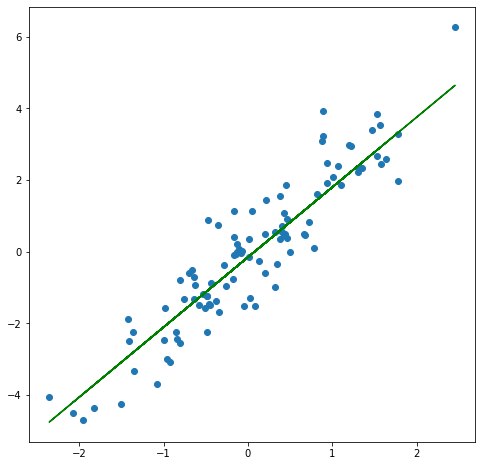

In [51]:
plt.figure(figsize = (8,8))
plt.plot(x,y,'o')
plt.plot(x,model1.predict(x),'g')
plt.show()o